### 1. Converting data to MNE and using its methods for spectral analysis

In this notebook I'll test a few MNE-python toolbox methods.

In [14]:
#####################################################################################################
# Read and save the LFP data and information for each trial in numpy format
#####################################################################################################
from   GDa.LFP              import LFP
from   joblib               import Parallel, delayed
import multiprocessing
import mne
import matplotlib.pyplot    as     plt
import numpy                as     np 
import matplotlib.animation as     animation

In [15]:
#####################################################################################################
# Receives a tensor [Nchannels, Nbands, Ntimes] and plot a movie containin the spec. for each channel
#####################################################################################################
def plot_movie(tensor, n_channels):
    fig = plt.figure()
    ims = []
    for i in range(n_channels):
        plt.title('Area: ' + info['ch_names'][i])
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [ms]')
        im = plt.imshow(tensor[i], aspect='auto', cmap='jet', origin='lower', extent=[0,3.51, 6, 60]) 
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                    repeat_delay=1000)

    writergif = animation.PillowWriter(fps=1)
    plt.show()
    #ani.save('power.gif',writer=writergif)

In [18]:
#####################################################################################################
# Receives a tensor [Nchannels, Nbands, Ntimes] and plot the spec. for each channel
#####################################################################################################
def plot_figs(tensor, n_channels):
    for i in range(n_channels):
        plt.figure()
        plt.title('Area: ' + info['ch_names'][i])
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [ms]')
        plt.imshow(tensor[i], aspect='auto', cmap='jet', origin='lower', extent=[0,3.51, 6, 60]) 
        plt.show()

In [2]:
nmonkey = 0
nses    = 3
ntype   = 0
#####################################################################################################
# Directories
#####################################################################################################
dirs = {'rawdata':'GrayLab/',
        'results':'Results/',
        'monkey' :['lucy', 'ethyl'],
        'session':'session01',
        'date'   :[['141014', '141015', '141205', '150128', '150211', '150304'], []]
        }

# Instatiate LFP object
lfp_data = LFP(raw_path = dirs['rawdata'], monkey = dirs['monkey'][nmonkey], stype = 'samplecor', date = dirs['date'][nmonkey][nses], 
               session  = 1, evt_dt = [-0.65,3.00])
# Read session info
lfp_data.read_session_info()
# Read LFP data
lfp_data.read_lfp_data()

Reading data...


Next I'll use "mne.EpochsArray" to create an object with the LFP data, and "mne.time_frequency.tfr_array_stockwell" to compute the spectogram for each recording channel.

In [3]:
#####################################################################################################
# Converting raw data into an Epoch Array
#####################################################################################################
info = mne.create_info(ch_names = lfp_data.readinfo['areas'].tolist(), sfreq= lfp_data.readinfo['fsample'])   
raw = mne.EpochsArray(lfp_data.data, info)
#con, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(raw, sfre = info['sfreq'], fmin=6, fmax=60, n_jobs=-1)  

540 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


<ipython-input-3-5998a323193d>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'DP', 'a8M', 'a7A', 'LIP', 'V2', 'F2', 'F1', 'a5', 'V6A', 'a3', 'V1', 'a7B'}. Applying running numbers for duplicates.
  info = mne.create_info(ch_names = lfp_data.readinfo['areas'].tolist(), sfreq= lfp_data.readinfo['fsample'])


0 bad epochs dropped


First I'll compute the spectogram for each channel but only the first trial.

In [12]:
st_power, itc, freqs = mne.time_frequency.tfr_array_stockwell(lfp_data.data[0,:,:][np.newaxis, :, :], info['sfreq'], fmin=6, fmax=60, n_jobs=-1)

<ipython-input-12-3b2df6e7edb9>:1: RuntimeWarning: The input signal is shorter (3651) than "n_fft" (4096). Applying zero padding.
  st_power, itc, freqs = mne.time_frequency.tfr_array_stockwell(lfp_data.data[0,:,:][np.newaxis, :, :], info['sfreq'], fmin=6, fmax=60, n_jobs=-1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    1.7s remaining:    2.5s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    2.3s remaining:    1.5s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    3.0s remaining:    0.7s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    3.7s finished


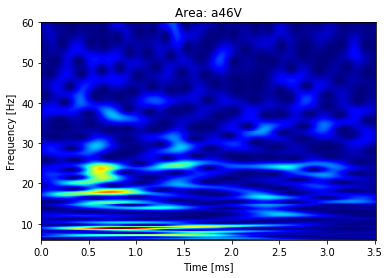

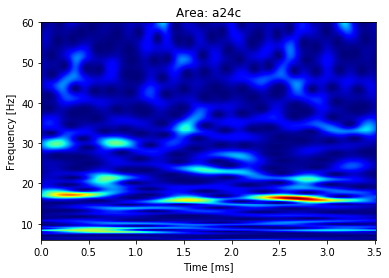

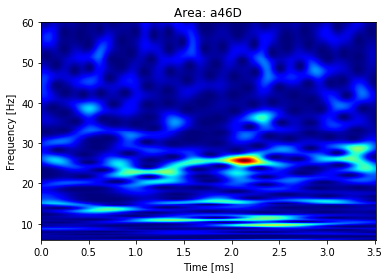

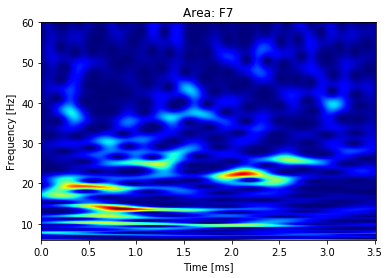

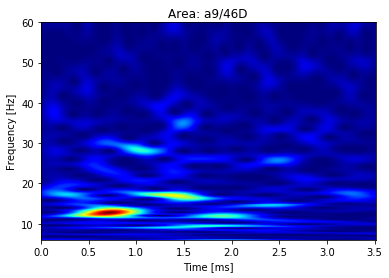

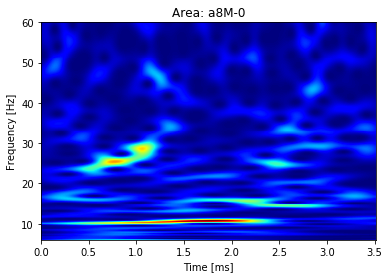

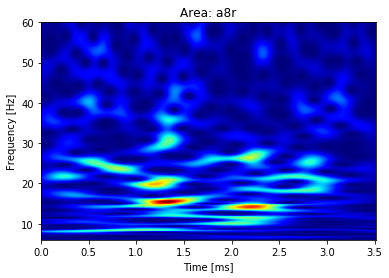

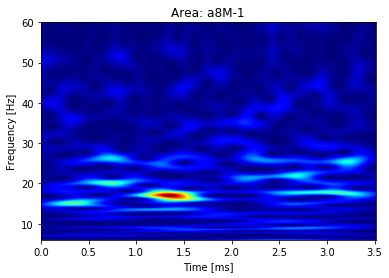

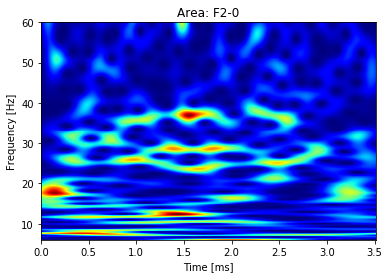

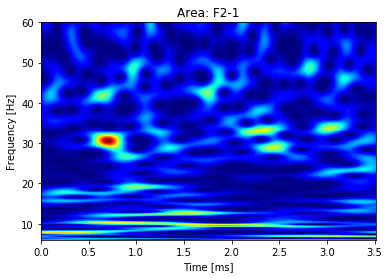

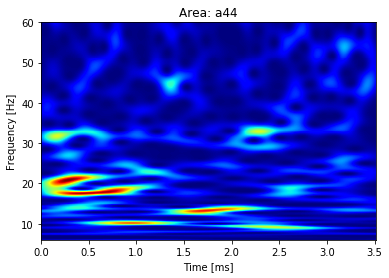

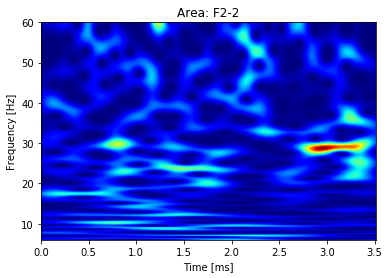

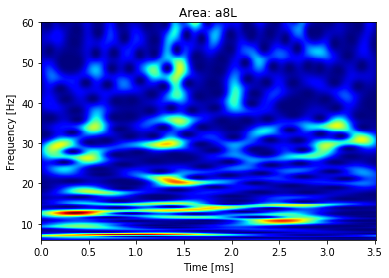

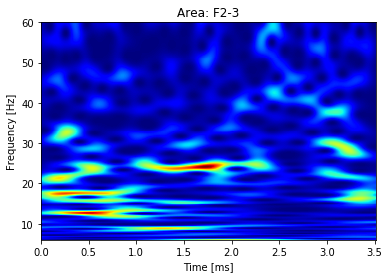

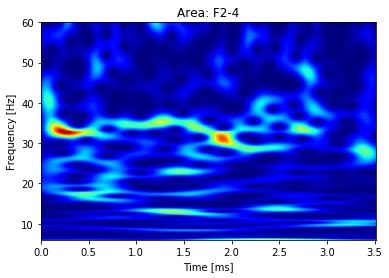

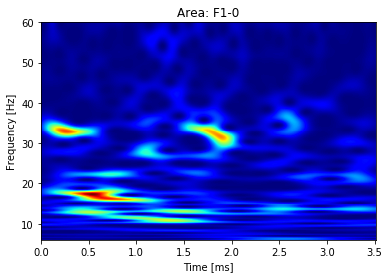

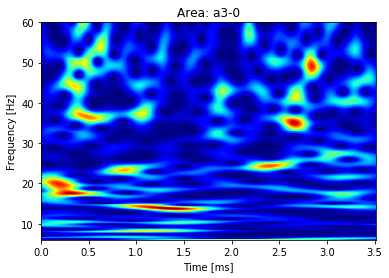

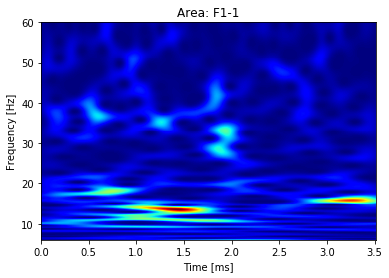

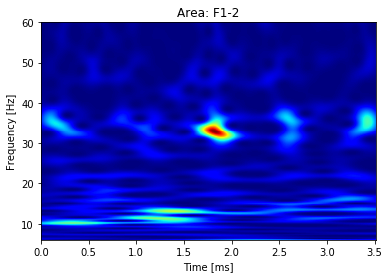

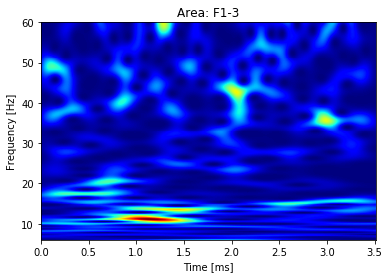

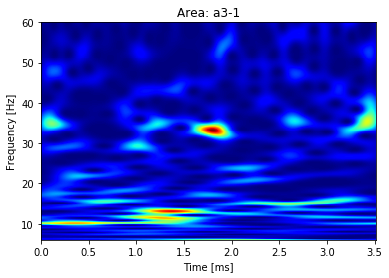

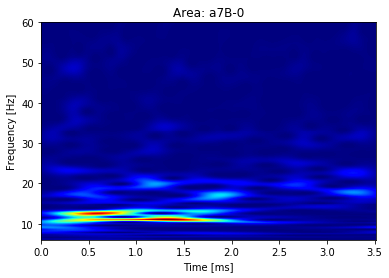

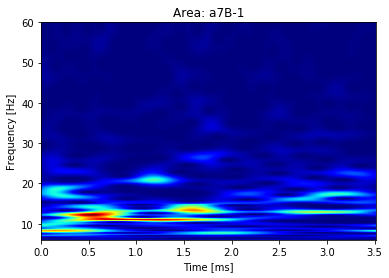

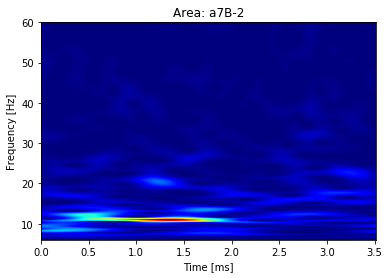

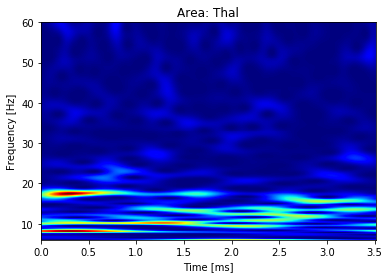

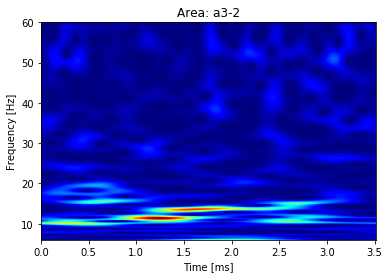

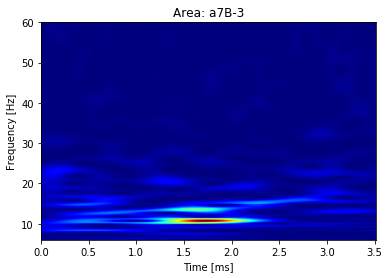

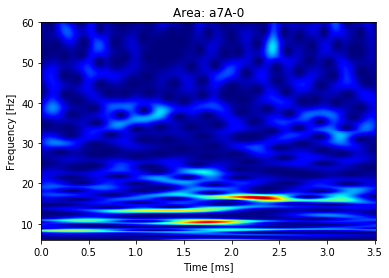

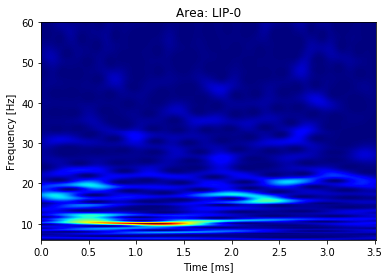

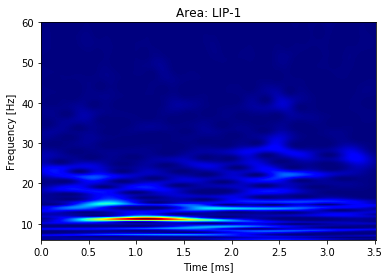

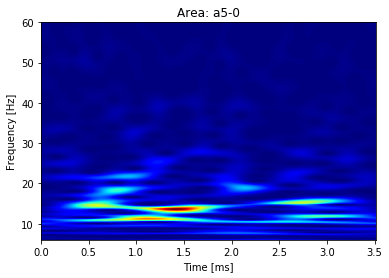

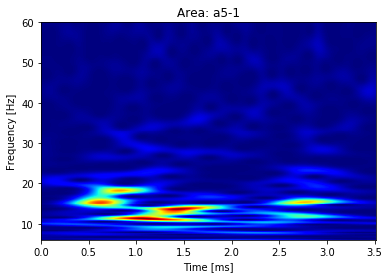

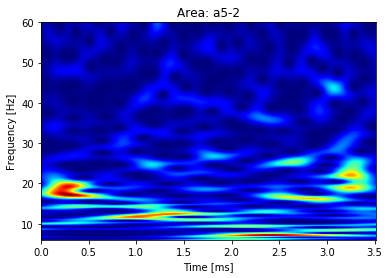

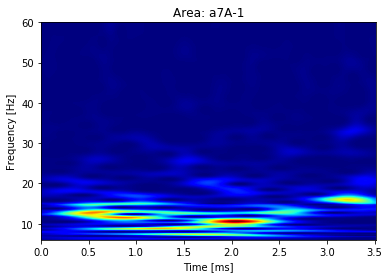

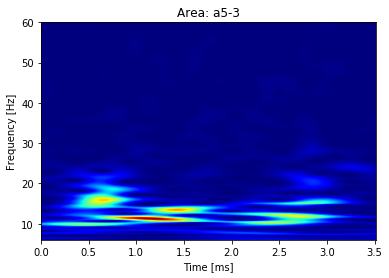

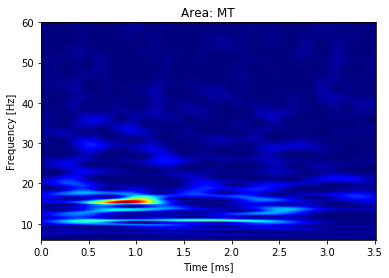

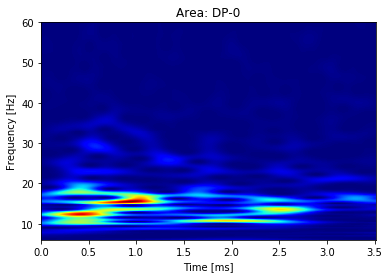

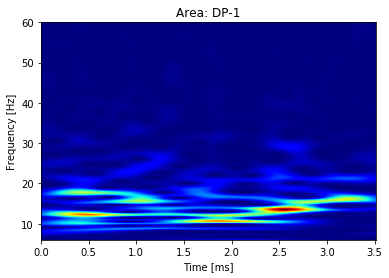

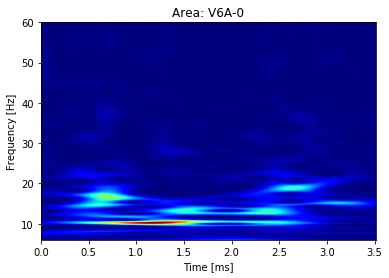

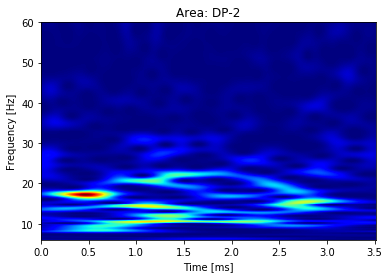

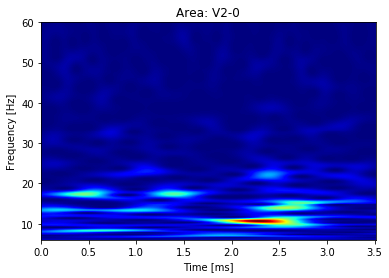

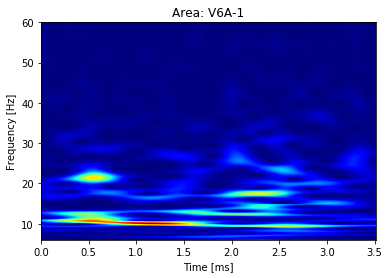

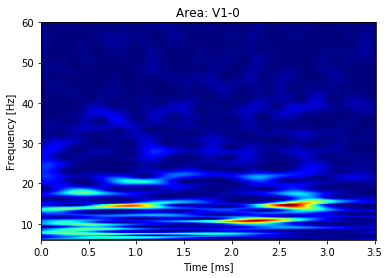

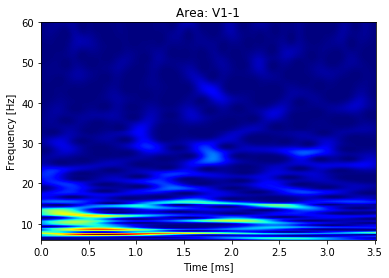

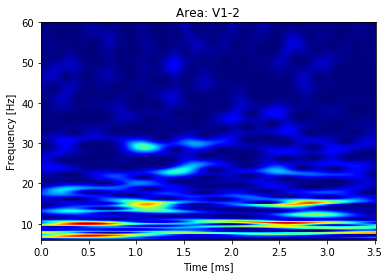

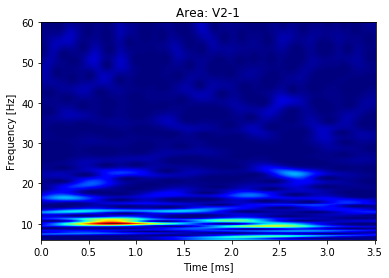

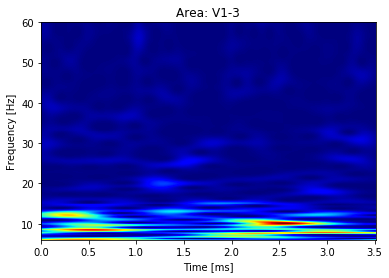

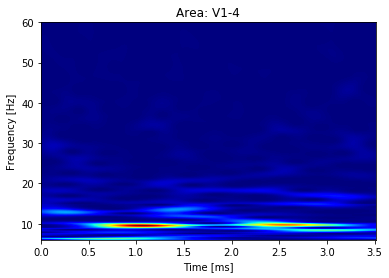

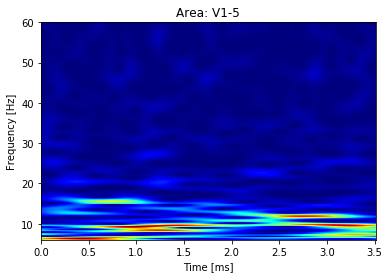

In [20]:
plot_figs(st_power, 49)

Now for all the trials at once, I think it averages the power for all trials in this case. 

In [21]:
st_power, itc, freqs = mne.time_frequency.tfr_array_stockwell(lfp_data.data, info['sfreq'], fmin=6, fmax=60, n_jobs=-1)

<ipython-input-21-01224772324b>:1: RuntimeWarning: The input signal is shorter (3651) than "n_fft" (4096). Applying zero padding.
  st_power, itc, freqs = mne.time_frequency.tfr_array_stockwell(lfp_data.data, info['sfreq'], fmin=6, fmax=60, n_jobs=-1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:  1.4min remaining:  2.0min
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:  1.5min remaining:   55.6s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:  1.6min remaining:   21.1s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:  1.9min finished


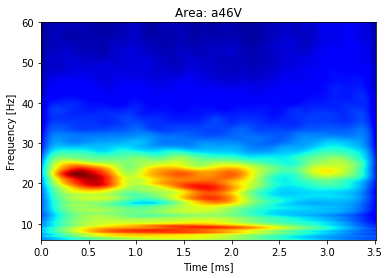

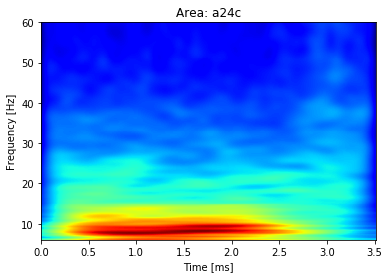

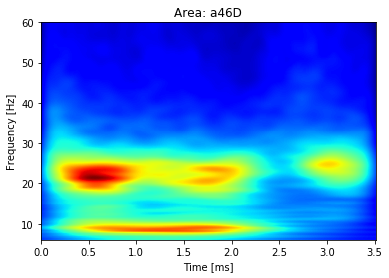

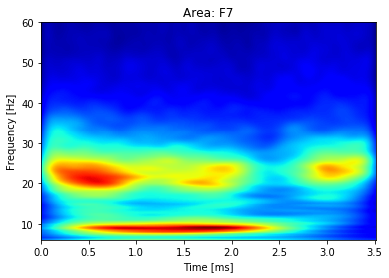

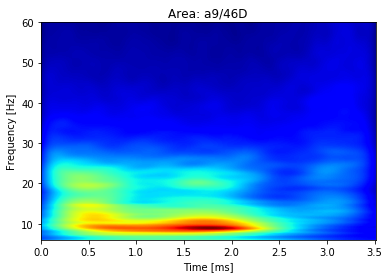

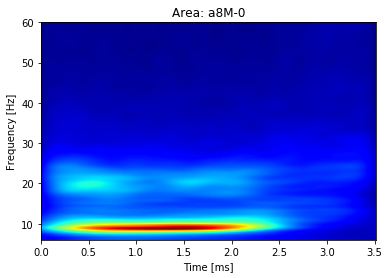

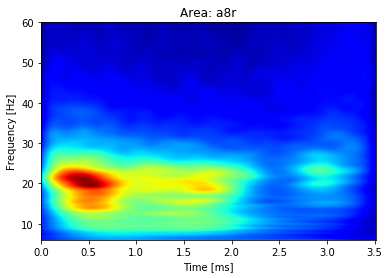

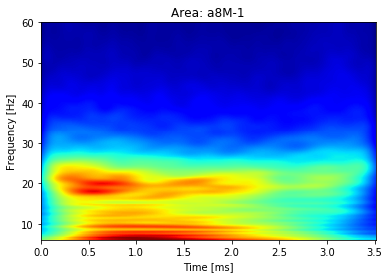

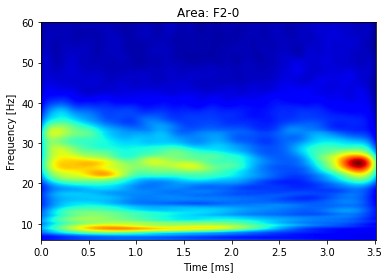

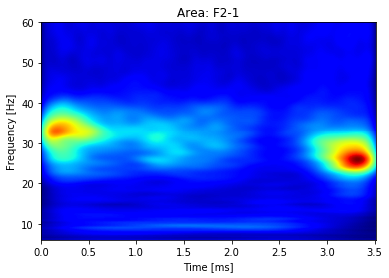

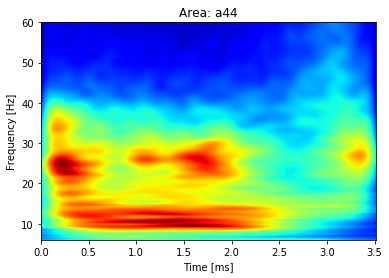

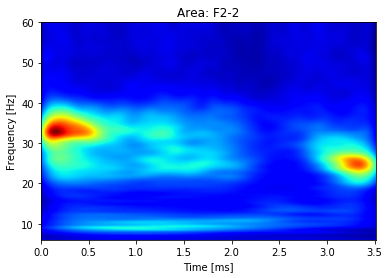

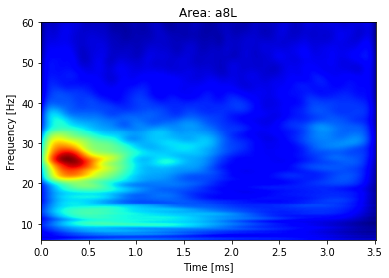

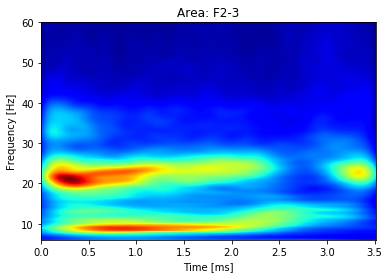

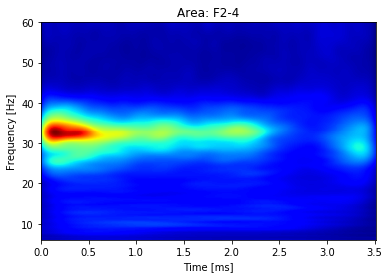

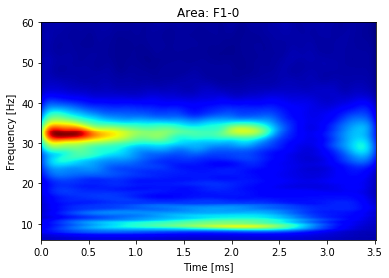

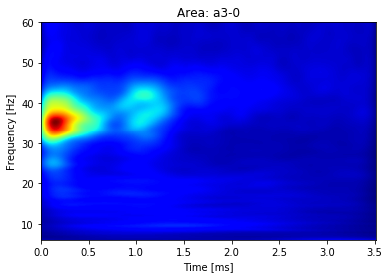

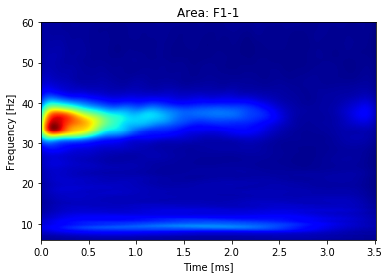

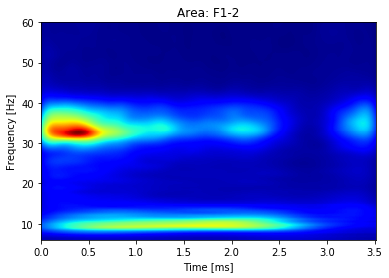

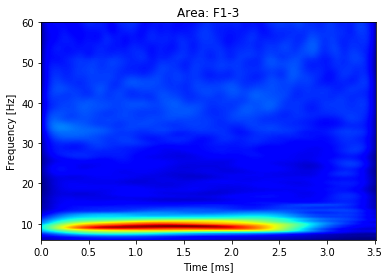

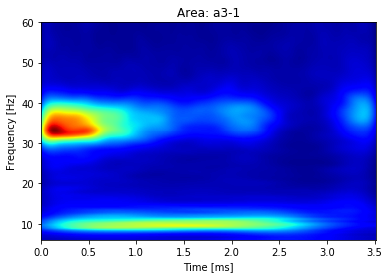

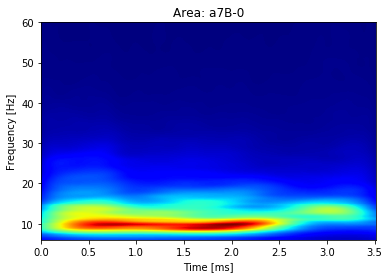

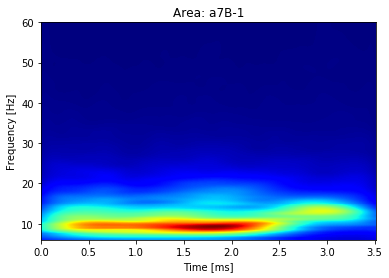

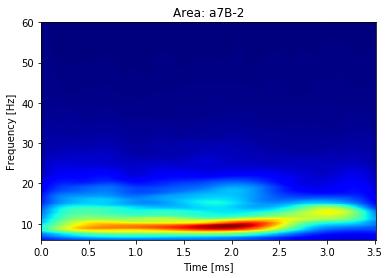

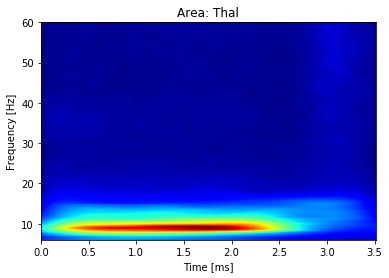

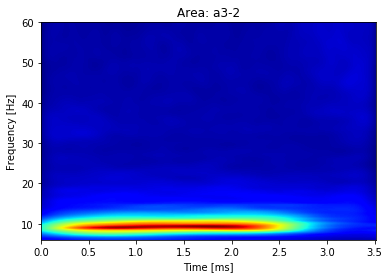

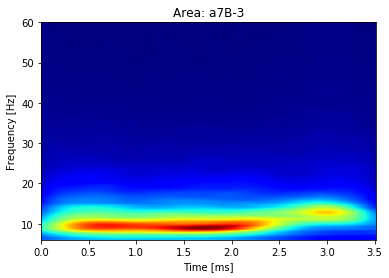

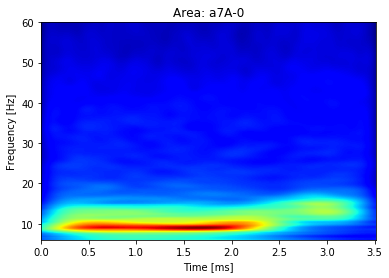

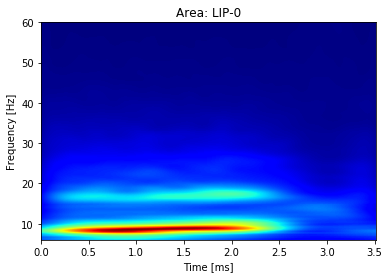

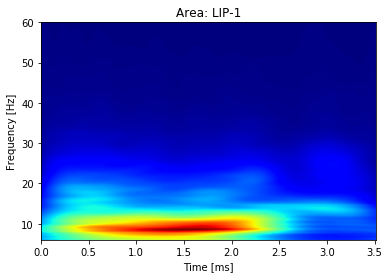

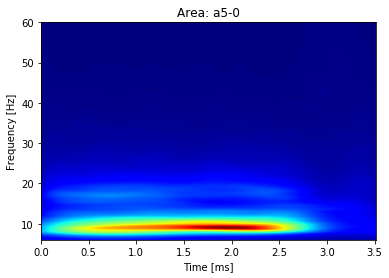

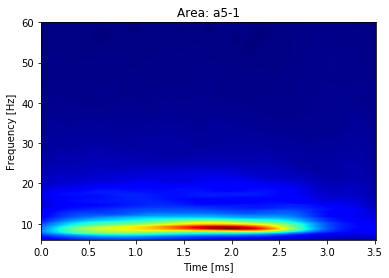

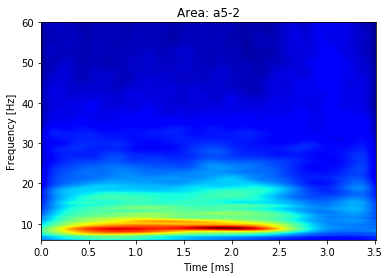

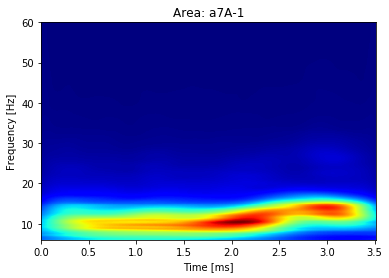

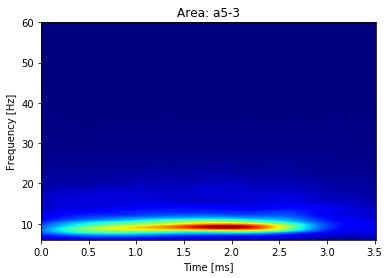

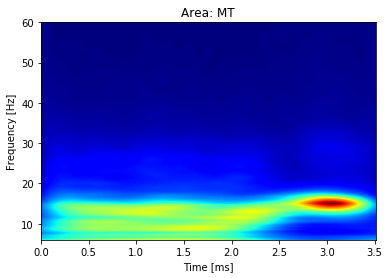

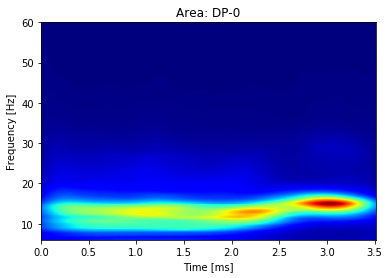

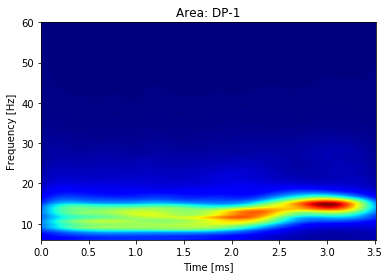

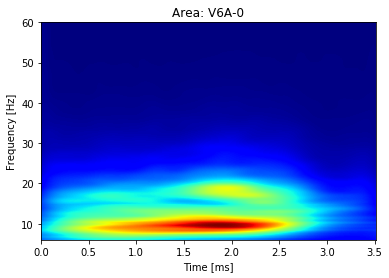

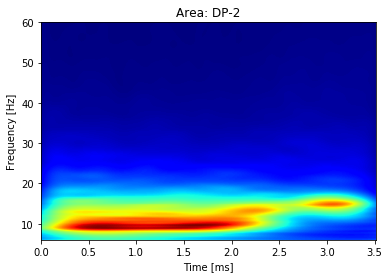

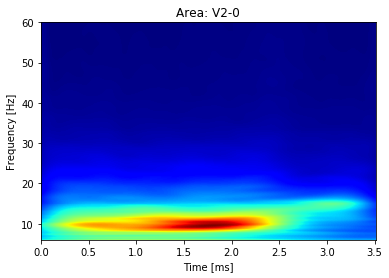

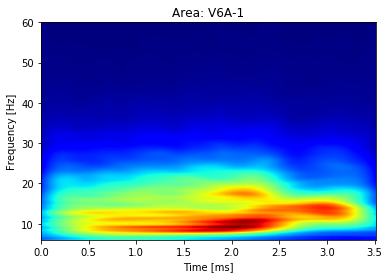

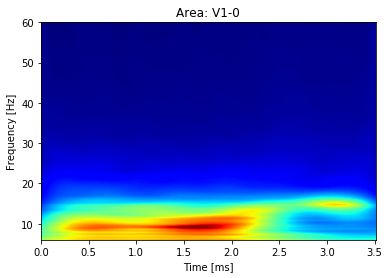

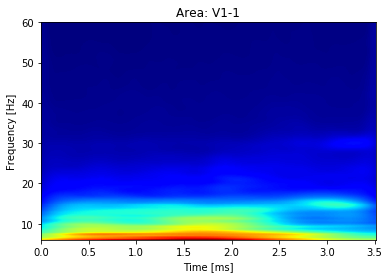

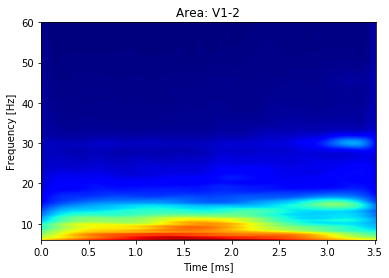

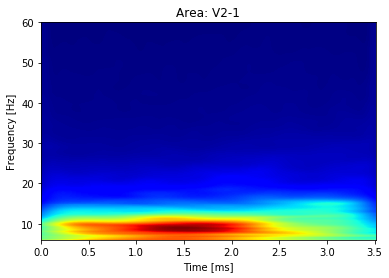

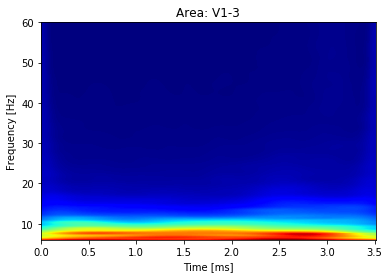

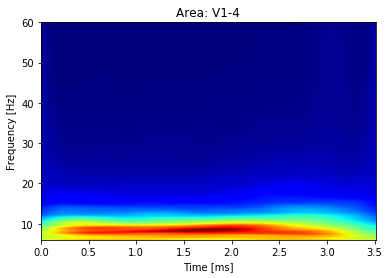

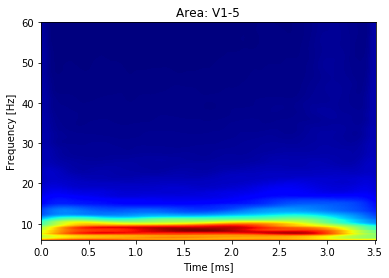

In [22]:
plot_figs(st_power, 49)

I've run it using 40 cores, so it is pretty fast! If we look at the documentation of "mne.time_frequency.tfr_array_stockwell" we see that it is possible to return the interareal coherences by setting "return_itc = True", let's test this for one trial of the data.

In [23]:
st_power, itc, freqs = mne.time_frequency.tfr_array_stockwell(lfp_data.data[0,:,:][np.newaxis, :, :], info['sfreq'], return_itc = True, fmin=6, fmax=60, n_jobs=-1)

<ipython-input-23-f4823f634bd4>:1: RuntimeWarning: The input signal is shorter (3651) than "n_fft" (4096). Applying zero padding.
  st_power, itc, freqs = mne.time_frequency.tfr_array_stockwell(lfp_data.data[0,:,:][np.newaxis, :, :], info['sfreq'], return_itc = True, fmin=6, fmax=60, n_jobs=-1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    3.8s remaining:    5.5s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    4.1s remaining:    2.6s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    4.4s remaining:    1.0s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    4.7s finished


The coherecens should be returned in the variable "itc", it returned all "1". I'll test another method called "mne.time_frequency.tfr_array_multitaper", the interareal coherences are returned by setting "ouput = 'itc'".

In [34]:
freqs = np.linspace(6, 60, 500)
out = mne.time_frequency.tfr_array_multitaper(lfp_data.data[0,:,:][np.newaxis, :, :], info['sfreq'], freqs, output='itc', n_jobs=-1, verbose=None)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    3.5s remaining:    5.0s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    4.5s remaining:    2.9s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    5.6s remaining:    1.3s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    6.4s finished


Apparently does not work as well.

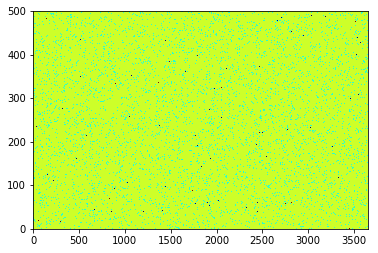

In [40]:
plt.imshow(out[1, :, :], aspect='auto', cmap='jet', origin='lower')

Testing the "mne.connectivity.spectral_connectivity" method for one trial.

In [41]:
con, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(lfp_data.data[0,:,:][np.newaxis, :, :], method='coh',  sfreq=info['sfreq'], mode='multitaper', fmin=6, fmax=60, n_jobs = -1)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1176 connections
    using t=0.000s..3.650s for estimation (3651 points)
    frequencies: 6.0Hz..60.0Hz (198 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..1


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    assembling connectivity matrix (filling the upper triangular region of the matrix)
[Connectivity computation done]


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished


We can plot the connetivity matrices for each frequency! Let's plot for ten different frequencies.

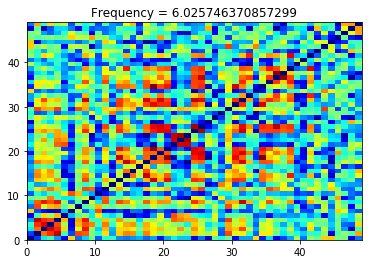

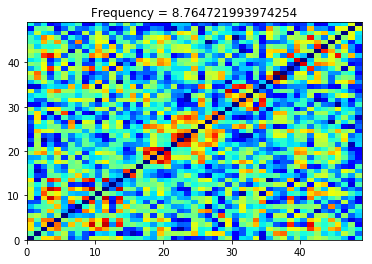

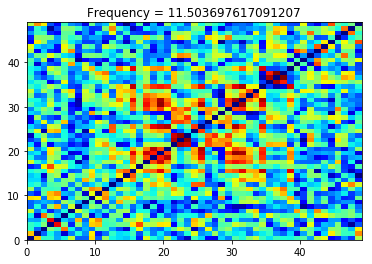

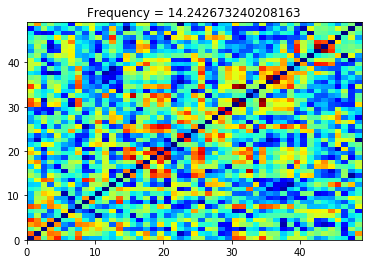

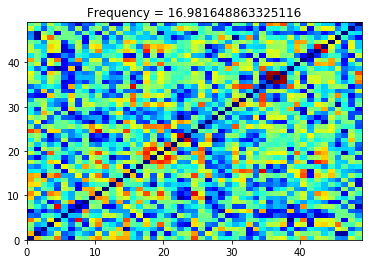

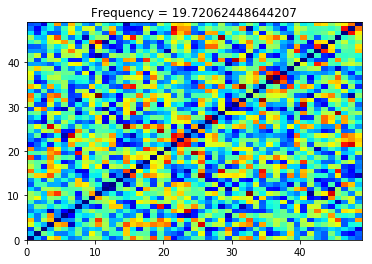

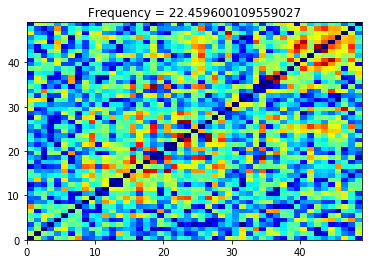

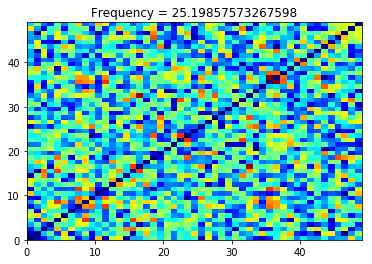

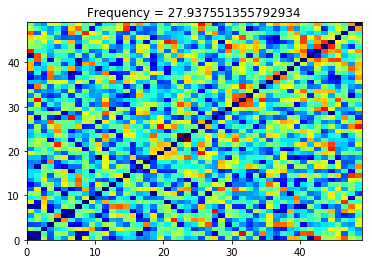

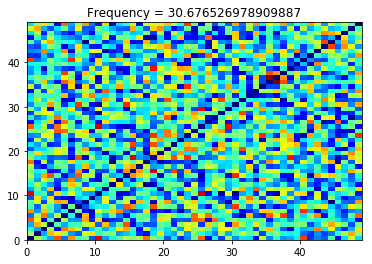

In [49]:
for i in [0, 10, 20, 30, 40, 50, 60,70, 80, 90]:
    plt.title('Frequency = ' + str(freqs[i]))
    plt.imshow(con[:,:,i]+con[:,:,i].T, aspect='auto', cmap='jet', extent=[0, 49, 0, 49], origin='lower')
    plt.show()